# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [92]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler



% matplotlib inline

# Data Understanding

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## 1. Portfolio Dataset

In [3]:
# take a look at the portfolio dataset
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [5]:
portfolio.shape

(10, 6)

In [6]:
portfolio['id'].value_counts()

4d5c57ea9a6940dd891ad53e9dbe8da0    1
2906b810c7d4411798c6938adc9daaa5    1
5a8bc65990b245e5a138643cd4eb9837    1
fafdcd668e3743c1bb461111dcafc2a4    1
3f207df678b143eea3cee63160fa8bed    1
ae264e3637204a6fb9bb56bc8210ddfd    1
9b98b8c7a33c4b65b9aebfe6a799e6d9    1
2298d6c36e964ae4a3e7e9706d1fb8c2    1
f19421c1d4aa40978ebb69ca19b0e20d    1
0b1e1539f2cc45b7b9fa7c272da2e1d7    1
Name: id, dtype: int64

In [7]:
portfolio['offer_type'].value_counts()

discount         4
bogo             4
informational    2
Name: offer_type, dtype: int64

In [8]:
# Find the unique channel values
channels_list = portfolio['channels'].tolist()
channels_list_flat = [channel for sublist in channels_list for channel in sublist]
set(channels_list_flat)

{'email', 'mobile', 'social', 'web'}

**Findings:** <br> 
1- There are only 10 rows in the Portfolio dataset where each row represents a unique offer id.<br> 
2- There are 3 offer types: BOGO, Discount and Informational.<br> 
3- Offers with the same offer type are assigned different difficulity, duration and reward values.<br> 
4- There are 4 channels: Email, Mobile, Social and Web.<br> 
5- There are no missing values in the Portfolio dataset.<br> 
<br> 
**Further Work:** <br> 
1- Change the name of id column to offer_id.<br> 
2- Convert the channels column to 4 binary columns representing each channel type.<br> 
4- Change the id values to new ids that are easier to intrepret.

## 2. Profile Dataset

In [9]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [10]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [11]:
profile['id'].nunique()

17000

Before exploring the null values, the dataset description states that the age value 118 represents a null value. Hence, we need to replace it to null. 

In [12]:
profile['age'] = profile['age'].replace(118, np.nan)

In [13]:
## Find the number of missing values
profile.isnull().sum()

age                 2175
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

We notice that 2175 rows are missing for all  the age, gender and income columns. However, it's not obvious if the same rows are missing these three values. Hence, we would love to check if those rows are exact by taking a subset of the profile df that has only the missing gender values.

In [14]:
# check if the rows missing the gender are the same row missing the income value.
profile_null_gender = profile[profile['gender'].isnull()]
profile_null_gender.isnull().sum()

age                 2175
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

Since the subset with 2175 rows of missing gender value has the same number of missing values in the age and income columns, it's clear that those rows are exactly the same. To help assisting us in choosing a method to treat them, we will look into the proportion of rows with missing values to the whole profile dataframe.

In [15]:
# Find the proportion of null values
2175/profile.shape[0] * 100

12.794117647058822

Since the proportion of missing values is only approximately 13%, we assume it's safe to drop them. However, a slight loss on information is a must.

Now, we want to explore the gender, age and income columns.

In [16]:
profile['gender'].value_counts()/(profile.shape[0]-2175) * 100

M    57.227656
F    41.342327
O     1.430017
Name: gender, dtype: float64

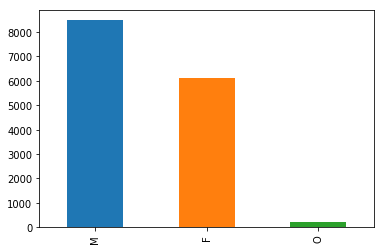

In [17]:
profile['gender'].value_counts().plot(kind= 'bar')

In [18]:
profile.groupby('gender')['age'].describe()

,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
F,6129.0,57.544950,16.883315,18.0,48.0,58.0,69.0,101.0
M,8484.0,52.116690,17.413894,18.0,39.0,53.0,65.0,100.0
O,212.0,54.400943,16.244710,20.0,43.0,55.0,66.0,100.0


In [19]:
profile.groupby('gender')['income'].describe()

,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
F,6129.0,71306.412139,22338.353773,30000.0,54000.0,71000.0,88000.0,120000.0
M,8484.0,61194.601603,20069.517615,30000.0,45000.0,59000.0,73000.0,120000.0
O,212.0,63287.735849,18938.594726,30000.0,51000.0,62000.0,79250.0,100000.0


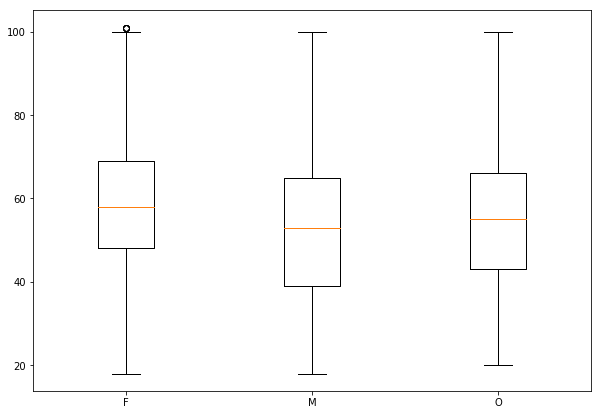

In [20]:
#plot the boxplots for the age of each gender group
age_F = profile[profile['gender'] == 'F']['age']
age_M = profile[profile['gender'] == 'M']['age']
age_O = profile[profile['gender'] == 'O']['age']

data = [age_F, age_M, age_O]
fig = plt.figure(figsize =(10, 7))
plt.boxplot(data)
plt.xticks([1, 2, 3], ['F', 'M', 'O'])
plt.show()

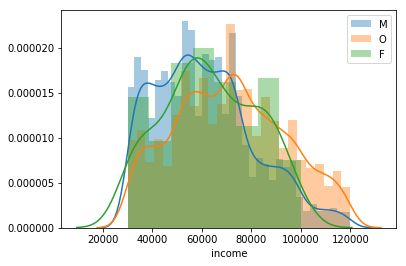

In [21]:
sns.distplot(profile[profile['gender']=='M']['income'],label='M')
sns.distplot(profile[profile['gender']=='F']['income'],label='O')
sns.distplot(profile[profile['gender']=='O']['income'],label='F')

plt.legend()
plt.show()

**Findings:** <br> 
1- The Profile dataset has 17000 entries of unique ids.<br> 
2- There are 2175 rows with missing values in the age, gender and income columns.<br> 
3- The rows with missing values are about 13% of the Profile dataset. <br>
4- The highest proportion of individual in the Profile dataset are males with 57%, then females with 41% while the O gender is only 1% of the dataset.<br> 
5- The mean age based on gender is 57 for Female, 54 for O and 52 for Male.<br> 
6- The mean income based on gender is 71306 for Female, 63287 for O and 61194 for Male.<br> 
7- The boxplot for age based on gender shows there is only one potentioal outlier for the female with age 101. However, this outlier is so close to upper whisker value of 100. Hence, we will consider it a valid value.<br> 
8- The distribution plot for income shows that the distribution of Male is almost right-skewed where the distribution of F and O is most likely a normal distribution.<br>

**Further Work:** <br> 
1- Change the name of id column to person_id.<br> 
2- Change the data type of became_member_on column to datetime.<br> 
3- Drop the missing values. <br> 

## 3. Transcript Dataset

In [22]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [23]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [24]:
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [25]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [26]:
# find the possible keys of the dictionary values in the value column
value_keys = []
for row in transcript['value'].tolist():
    for key, value in row.items():
        value_keys.append(key)
set(value_keys)

{'amount', 'offer id', 'offer_id', 'reward'}

**Findings:** <br> 
1- The Transcript dataset has 306534 entries that compromises of an entry for each event of an offer for different individuals.<br> 
2- There are no missing values.<br> 
3- The event column has 4 possible values: offer recieved, offer viewed, transaction and offer completed.<br>
4- The value column consist of dictionary with four possible keys: offer id, offer_id, reward and amount. However, offer id and offer_id means the same thing so we need to preprocess their names for consistency. 

**Further Work:** <br> 
1- Change the name of person column to person_id.<br> 
2- Convert the value column for new 4 different columns (offer id, offer_id, reward and amount).<br>
3- Use one-hot-enconding on the event column.<br> 
4- Study the resulting df for further work.

# Dataset Preprocessing

## 1. Portfolio Dataset

In [27]:
# Convert the channels column to 4 binary columns representing each channel type.
portfolio['email_channel'] = portfolio['channels'].apply(lambda lst: 1 if 'email' in lst else 0)
portfolio['mobile_channel'] = portfolio['channels'].apply(lambda lst: 1 if 'mobile' in lst else 0)
portfolio['web_channel'] = portfolio['channels'].apply(lambda lst: 1 if 'web' in lst else 0)
portfolio['social_channel'] = portfolio['channels'].apply(lambda lst: 1 if 'social' in lst else 0)

In [28]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward,email_channel,mobile_channel,web_channel,social_channel
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,0,1
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,1,0


In [29]:
# rename the id coulumn to offer_id
portfolio.rename(columns={'id':'offer_id'}, inplace=True)
portfolio.head()

,channels,difficulty,duration,offer_id,offer_type,reward,email_channel,mobile_channel,web_channel,social_channel
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,0,1
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,1,0


In [30]:
# map the offer_id column to the offer_dic to rename the offer_id values
offer_dic = {'ae264e3637204a6fb9bb56bc8210ddfd': '1',
             '4d5c57ea9a6940dd891ad53e9dbe8da0':'2',
             '3f207df678b143eea3cee63160fa8bed':'3',
             '9b98b8c7a33c4b65b9aebfe6a799e6d9':'4',
             '0b1e1539f2cc45b7b9fa7c272da2e1d7':'5',
             '2298d6c36e964ae4a3e7e9706d1fb8c2':'6',
             'fafdcd668e3743c1bb461111dcafc2a4':'7',
             '5a8bc65990b245e5a138643cd4eb9837':'8',
             'f19421c1d4aa40978ebb69ca19b0e20d':'9',
             '2906b810c7d4411798c6938adc9daaa5':'10'
             }
portfolio['offer_id'] = portfolio['offer_id'].map(offer_dic)
portfolio.head()

,channels,difficulty,duration,offer_id,offer_type,reward,email_channel,mobile_channel,web_channel,social_channel
0,"[email, mobile, social]",10,7,1,bogo,10,1,1,0,1
1,"[web, email, mobile, social]",10,5,2,bogo,10,1,1,1,1
2,"[web, email, mobile]",0,4,3,informational,0,1,1,1,0
3,"[web, email, mobile]",5,7,4,bogo,5,1,1,1,0
4,"[web, email]",20,10,5,discount,5,1,0,1,0


## 2. Profile Dataset

In [31]:
# change the became_member_on column type to datetime format
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile.dtypes

age                        float64
became_member_on    datetime64[ns]
gender                      object
id                          object
income                     float64
dtype: object

In [32]:
# Change the name of id column to person_id
profile.rename(columns={'id':'person_id'}, inplace=True)
profile.head()

,age,became_member_on,gender,person_id,income
0,NaN,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,NaN,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,NaN,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [33]:
# Drop the missing values.
profile.dropna(inplace=True)
profile.shape

(14825, 5)

In [34]:
profile.head()

,age,became_member_on,gender,person_id,income
1,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68.0,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65.0,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58.0,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


## 3. Transcript Dataset

In [35]:
# Change the name of person column to person_id
transcript.rename(columns={'person':'person_id'}, inplace=True)

In [36]:
# Convert the value column for new 4 different columns (offer id, offer_id, reward and amount)
value_df = pd.DataFrame(transcript['value'].tolist())
new_transcript = pd.concat([transcript, value_df], sort=False, axis=1)
new_transcript.head()

,event,person_id,time,value,amount,offer id,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [37]:
# merge offer id and offer_id columns to a single columns named offer_id
new_transcript['offer_id'] = new_transcript['offer_id'].fillna('') + new_transcript['offer id']
new_transcript.drop(['offer id'], axis=1, inplace=True)

In [38]:
# drop the value column
new_transcript.drop(['value'], axis=1, inplace=True)
new_transcript.head()

,event,person_id,time,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [39]:
# map the offer_id column to the offer_dic to rename the offer_id values
offer_dic = {'ae264e3637204a6fb9bb56bc8210ddfd': '1',
             '4d5c57ea9a6940dd891ad53e9dbe8da0':'2',
             '3f207df678b143eea3cee63160fa8bed':'3',
             '9b98b8c7a33c4b65b9aebfe6a799e6d9':'4',
             '0b1e1539f2cc45b7b9fa7c272da2e1d7':'5',
             '2298d6c36e964ae4a3e7e9706d1fb8c2':'6',
             'fafdcd668e3743c1bb461111dcafc2a4':'7',
             '5a8bc65990b245e5a138643cd4eb9837':'8',
             'f19421c1d4aa40978ebb69ca19b0e20d':'9',
             '2906b810c7d4411798c6938adc9daaa5':'10'
             }
new_transcript['offer_id'] = new_transcript['offer_id'].map(offer_dic)
new_transcript.head()

,event,person_id,time,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,4,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,5,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,10,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,7,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,2,NaN


In [40]:
new_transcript.groupby('event').count()

,person_id,time,amount,offer_id,reward
event,,,,,
offer completed,33579,33579,0,0,33579
offer received,76277,76277,0,76277,0
offer viewed,57725,57725,0,57725,0
transaction,138953,138953,138953,0,0


By grouping the dataset based on event columns, we can conclude the following: <br>
1- offer completed event has an associated reward value. However, it doesn't have amount neither offer_id values.<br>
2- offer received and over viewed events have an associated offer_id but no amount or reward values.<br>
3- transaction event have an associated amount but no offer_id or reward values.<br>

### Next Steps.. 
We want to define a criteria for a successful offer. We can consider an offer successful if the customer has made a transaction or completed that offer upon receving and viewing it.<br>
However, as seen previously the transaction and offer completed event are missing the offer_id value. Hence, the first step will be filling these missing values with a offer id. One way to do so is by using forward fill. <br>
First, we will sort the transcript df based on person and time and then we will use the ffill() method to fill the missing offer_id values.

In [41]:
# sort the new_transcript based on person and time
ffill_transcript = new_transcript.sort_values(['person_id', 'time'])

# forward fill the offer_id column
ffill_transcript['offer_id'] = ffill_transcript['offer_id'].ffill().loc[ffill_transcript.index]
ffill_transcript.head(10)

,event,person_id,time,amount,offer_id,reward
55972,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,8,NaN
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,8,NaN
89291,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,8,NaN
113605,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,3,NaN
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,3,NaN
153401,offer received,0009655768c64bdeb2e877511632db8f,408,NaN,9,NaN
168412,transaction,0009655768c64bdeb2e877511632db8f,414,8.57,9,NaN
168413,offer completed,0009655768c64bdeb2e877511632db8f,414,NaN,9,5.0
187554,offer viewed,0009655768c64bdeb2e877511632db8f,456,NaN,9,NaN
204340,offer received,0009655768c64bdeb2e877511632db8f,504,NaN,7,NaN


In [42]:
ffill_transcript['offer_id'].isna().sum()

0

In [43]:
# Use one-hot-enconding on the event column 
dummy_transcript = pd.concat([ffill_transcript, pd.get_dummies(ffill_transcript['event'])], sort=False, axis=1)
dummy_transcript.head()

,event,person_id,time,amount,offer_id,reward,offer completed,offer received,offer viewed,transaction
55972,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,8,NaN,0,1,0,0
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,8,NaN,0,0,1,0
89291,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,8,NaN,0,0,0,1
113605,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,3,NaN,0,1,0,0
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,3,NaN,0,0,1,0


Now, we are going to combine the rows with a common person_id and offer_id pair into a single row by aggregating the sum of the rest of rows. 

In [44]:
# group by person_id and offer_id and takes the sum of rows.
processed_transcript = dummy_transcript.groupby(['person_id', 'offer_id']).sum().reset_index()
processed_transcript.head()

,person_id,offer_id,time,amount,reward,offer completed,offer received,offer viewed,transaction
0,0009655768c64bdeb2e877511632db8f,10,3774,69.20,2.0,1,1,0,4
1,0009655768c64bdeb2e877511632db8f,3,708,0.00,0.0,0,1,1,0
2,0009655768c64bdeb2e877511632db8f,7,2652,27.67,2.0,1,1,1,2
3,0009655768c64bdeb2e877511632db8f,8,588,22.16,0.0,0,1,1,1
4,0009655768c64bdeb2e877511632db8f,9,1692,8.57,5.0,1,1,1,1


## 4- Merging the Datasets

In [45]:
# merge the 
temp = pd.merge(processed_transcript,portfolio,how='inner',on='offer_id')
temp.head()

,person_id,offer_id,time,amount,reward_x,offer completed,offer received,offer viewed,transaction,channels,difficulty,duration,offer_type,reward_y,email_channel,mobile_channel,web_channel,social_channel
0,0009655768c64bdeb2e877511632db8f,10,3774,69.20,2.0,1,1,0,4,"[web, email, mobile]",10,7,discount,2,1,1,1,0
1,00426fe3ffde4c6b9cb9ad6d077a13ea,10,3438,7.84,0.0,0,2,0,4,"[web, email, mobile]",10,7,discount,2,1,1,1,0
2,004b041fbfe44859945daa2c7f79ee64,10,18,25.62,0.0,0,0,0,1,"[web, email, mobile]",10,7,discount,2,1,1,1,0
3,005500a7188546ff8a767329a2f7c76a,10,408,0.00,0.0,0,1,0,0,"[web, email, mobile]",10,7,discount,2,1,1,1,0
4,0069a50874d846438e58acff5e594725,10,3642,13.09,2.0,1,2,1,2,"[web, email, mobile]",10,7,discount,2,1,1,1,0


In [46]:
temp.shape

(65028, 18)

After merging the transcript and portfolio datasets, we want to keep only the valid entries and remove the invalid ones. Remember we filled the offer_id values for the transaction and offer completed columns using forward fill as the actual offer_id values were missing in the dataset. However, this method might resulted in filling wrong offer_id values (not the actual offer_id. <br>
Since we want our dataset to be as consistent as possible, we are going to keep only the valid rows. <br>
<br>
The valid rows must fulfill the two following conditions:<br>
1- The reward obtained by the customer must be equal to the reward value for the offer * the number of times the customer has completed that offer.<br>
2- For those customers whom completed the offer, the amount they spent must be greater than or equal to the difficulity of that offer (the amount they must spend to complete the offer).

In [47]:
# find the invalid rows and store them in invalid df
invalid = temp[(temp['reward_x'] != (temp['reward_y'] * temp['offer completed'])) | ((temp['amount'] < temp['difficulty']) & (temp['offer completed'] > 0))]

In [48]:
# keep only the valid rows
valid = temp[~temp.isin(invalid)].dropna()

In [49]:
# merge the temp df with the profile df
master = pd.merge(temp,profile,how='inner',on='person_id')
master.head()

,person_id,offer_id,time,amount,reward_x,offer completed,offer received,offer viewed,transaction,channels,...,offer_type,reward_y,email_channel,mobile_channel,web_channel,social_channel,age,became_member_on,gender,income
0,0009655768c64bdeb2e877511632db8f,10,3774,69.20,2.0,1,1,0,4,"[web, email, mobile]",...,discount,2,1,1,1,0,33.0,2017-04-21,M,72000.0
1,0009655768c64bdeb2e877511632db8f,3,708,0.00,0.0,0,1,1,0,"[web, email, mobile]",...,informational,0,1,1,1,0,33.0,2017-04-21,M,72000.0
2,0009655768c64bdeb2e877511632db8f,7,2652,27.67,2.0,1,1,1,2,"[web, email, mobile, social]",...,discount,2,1,1,1,1,33.0,2017-04-21,M,72000.0
3,0009655768c64bdeb2e877511632db8f,8,588,22.16,0.0,0,1,1,1,"[email, mobile, social]",...,informational,0,1,1,0,1,33.0,2017-04-21,M,72000.0
4,0009655768c64bdeb2e877511632db8f,9,1692,8.57,5.0,1,1,1,1,"[web, email, mobile, social]",...,bogo,5,1,1,1,1,33.0,2017-04-21,M,72000.0


In [50]:
master.groupby('offer_type').sum()

,time,amount,reward_x,offer completed,offer received,offer viewed,transaction,difficulty,duration,reward_y,email_channel,mobile_channel,web_channel,social_channel,age,income
offer_type,,,,,,,,,,,,,,,,
bogo,42621198,719904.11,109035.0,15694.0,26537.0,22039.0,52212.0,170225,136105,170225,22665,22665,16958,16982,1229572.0,1.479386e+09
discount,41580444,740364.32,47044.0,15789.0,26664.0,18461.0,51960.0,267826,193557,68403,22752,17015,22752,11382,1235558.0,1.487567e+09
informational,15822282,274673.97,4462.0,961.0,13300.0,9360.0,19785.0,0,39703,0,11342,11342,5677,5665,618041.0,7.415080e+08


## Define Successful Offer Methodology
We have 3 types of offer: bogo, discount and informational. The informational offers are mere advertisments that have no difficulity or reward upon completetion assigend to them. <br>
Therefore, we will define a **successful informational offer** as follows: offer viewed & transaction has been made.<br>
On the other hand, a **successful bogo and discount offers** will be determined if: offer viewed & offer completed. <br>

In [51]:
master['successful_offer'] = np.nan
master.head()

,person_id,offer_id,time,amount,reward_x,offer completed,offer received,offer viewed,transaction,channels,...,reward_y,email_channel,mobile_channel,web_channel,social_channel,age,became_member_on,gender,income,successful_offer
0,0009655768c64bdeb2e877511632db8f,10,3774,69.20,2.0,1,1,0,4,"[web, email, mobile]",...,2,1,1,1,0,33.0,2017-04-21,M,72000.0,NaN
1,0009655768c64bdeb2e877511632db8f,3,708,0.00,0.0,0,1,1,0,"[web, email, mobile]",...,0,1,1,1,0,33.0,2017-04-21,M,72000.0,NaN
2,0009655768c64bdeb2e877511632db8f,7,2652,27.67,2.0,1,1,1,2,"[web, email, mobile, social]",...,2,1,1,1,1,33.0,2017-04-21,M,72000.0,NaN
3,0009655768c64bdeb2e877511632db8f,8,588,22.16,0.0,0,1,1,1,"[email, mobile, social]",...,0,1,1,0,1,33.0,2017-04-21,M,72000.0,NaN
4,0009655768c64bdeb2e877511632db8f,9,1692,8.57,5.0,1,1,1,1,"[web, email, mobile, social]",...,5,1,1,1,1,33.0,2017-04-21,M,72000.0,NaN


In [52]:
# determine if the offer is successful for the informational offer type
master.loc[master['offer_type'] == 'informational', ['successful_offer']]= master.apply(
    lambda row: 1 if ((row['transaction'] > 0) & (row['offer viewed'] > 0)) else 0, axis=1)


# determine if the offer is successful for the bogo and discount offer type
master.loc[master['offer_type'] != 'informational', ['successful_offer']]= master.apply(
    lambda row: 1 if ((row['offer completed'] > 0) & (row['offer viewed'] > 0)) else 0, axis=1)

master.head()

,person_id,offer_id,time,amount,reward_x,offer completed,offer received,offer viewed,transaction,channels,...,reward_y,email_channel,mobile_channel,web_channel,social_channel,age,became_member_on,gender,income,successful_offer
0,0009655768c64bdeb2e877511632db8f,10,3774,69.20,2.0,1,1,0,4,"[web, email, mobile]",...,2,1,1,1,0,33.0,2017-04-21,M,72000.0,0.0
1,0009655768c64bdeb2e877511632db8f,3,708,0.00,0.0,0,1,1,0,"[web, email, mobile]",...,0,1,1,1,0,33.0,2017-04-21,M,72000.0,0.0
2,0009655768c64bdeb2e877511632db8f,7,2652,27.67,2.0,1,1,1,2,"[web, email, mobile, social]",...,2,1,1,1,1,33.0,2017-04-21,M,72000.0,1.0
3,0009655768c64bdeb2e877511632db8f,8,588,22.16,0.0,0,1,1,1,"[email, mobile, social]",...,0,1,1,0,1,33.0,2017-04-21,M,72000.0,1.0
4,0009655768c64bdeb2e877511632db8f,9,1692,8.57,5.0,1,1,1,1,"[web, email, mobile, social]",...,5,1,1,1,1,33.0,2017-04-21,M,72000.0,1.0


Now, we create new column named num_success indicating the number of successful offers for each person

In [53]:
# create the num_success column
master['num_success'] = master.groupby('person_id')['successful_offer'].transform('sum')
master.head(10)

,person_id,offer_id,time,amount,reward_x,offer completed,offer received,offer viewed,transaction,channels,...,email_channel,mobile_channel,web_channel,social_channel,age,became_member_on,gender,income,successful_offer,num_success
0,0009655768c64bdeb2e877511632db8f,10,3774,69.20,2.0,1,1,0,4,"[web, email, mobile]",...,1,1,1,0,33.0,2017-04-21,M,72000.0,0.0,3.0
1,0009655768c64bdeb2e877511632db8f,3,708,0.00,0.0,0,1,1,0,"[web, email, mobile]",...,1,1,1,0,33.0,2017-04-21,M,72000.0,0.0,3.0
2,0009655768c64bdeb2e877511632db8f,7,2652,27.67,2.0,1,1,1,2,"[web, email, mobile, social]",...,1,1,1,1,33.0,2017-04-21,M,72000.0,1.0,3.0
3,0009655768c64bdeb2e877511632db8f,8,588,22.16,0.0,0,1,1,1,"[email, mobile, social]",...,1,1,0,1,33.0,2017-04-21,M,72000.0,1.0,3.0
4,0009655768c64bdeb2e877511632db8f,9,1692,8.57,5.0,1,1,1,1,"[web, email, mobile, social]",...,1,1,1,1,33.0,2017-04-21,M,72000.0,1.0,3.0
5,00426fe3ffde4c6b9cb9ad6d077a13ea,10,3438,7.84,0.0,0,2,0,4,"[web, email, mobile]",...,1,1,1,0,19.0,2016-08-09,F,65000.0,0.0,2.0
6,00426fe3ffde4c6b9cb9ad6d077a13ea,7,1548,25.03,2.0,1,1,1,4,"[web, email, mobile, social]",...,1,1,1,1,19.0,2016-08-09,F,65000.0,1.0,2.0
7,00426fe3ffde4c6b9cb9ad6d077a13ea,8,498,30.92,0.0,0,1,1,7,"[email, mobile, social]",...,1,1,0,1,19.0,2016-08-09,F,65000.0,1.0,2.0
8,00426fe3ffde4c6b9cb9ad6d077a13ea,5,1020,4.72,0.0,0,1,0,2,"[web, email]",...,1,0,1,0,19.0,2016-08-09,F,65000.0,0.0,2.0
9,004b041fbfe44859945daa2c7f79ee64,10,18,25.62,0.0,0,0,0,1,"[web, email, mobile]",...,1,1,1,0,55.0,2018-05-08,F,74000.0,0.0,2.0


In [54]:
# drop the unneccesary columns
master.drop(['person_id', 'time', 'offer completed', 'offer received', 'offer viewed', 'transaction', 'channels'], axis=1, inplace=True)

In [55]:
# store only the year from became_member_on column in new column memebership_year
master['memebership_year'] = pd. DatetimeIndex(master['became_member_on']).year
master['became_member_on'].dtype

dtype('<M8[ns]')

In [56]:
master.head()

,offer_id,amount,reward_x,difficulty,duration,offer_type,reward_y,email_channel,mobile_channel,web_channel,social_channel,age,became_member_on,gender,income,successful_offer,num_success,memebership_year
0,10,69.20,2.0,10,7,discount,2,1,1,1,0,33.0,2017-04-21,M,72000.0,0.0,3.0,2017
1,3,0.00,0.0,0,4,informational,0,1,1,1,0,33.0,2017-04-21,M,72000.0,0.0,3.0,2017
2,7,27.67,2.0,10,10,discount,2,1,1,1,1,33.0,2017-04-21,M,72000.0,1.0,3.0,2017
3,8,22.16,0.0,0,3,informational,0,1,1,0,1,33.0,2017-04-21,M,72000.0,1.0,3.0,2017
4,9,8.57,5.0,5,5,bogo,5,1,1,1,1,33.0,2017-04-21,M,72000.0,1.0,3.0,2017


# Analysing the Master Dataset

In [57]:
master['successful_offer'].value_counts()

0.0    28820
1.0    27939
Name: successful_offer, dtype: int64

In [58]:
master.shape

(56759, 18)

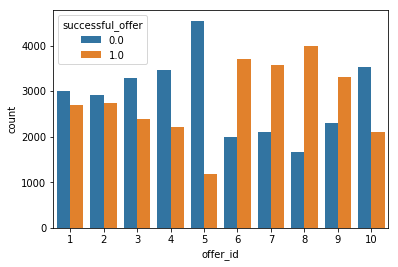

In [59]:
# plot the number of successful and unsuccesful offers based on offer_id
sns.countplot(x="offer_id", hue="successful_offer", data=master, order=['1','2','3','4','5','6','7','8','9','10'])

In [60]:
# take a look at offer 8 and 5
portfolio[(portfolio['offer_id'] == '5') | (portfolio['offer_id'] == '8')]

,channels,difficulty,duration,offer_id,offer_type,reward,email_channel,mobile_channel,web_channel,social_channel
4,"[web, email]",20,10,5,discount,5,1,0,1,0
7,"[email, mobile, social]",0,3,8,informational,0,1,1,0,1


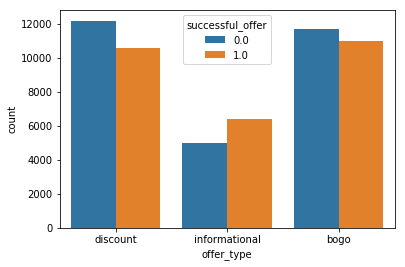

In [61]:
sns.countplot(x="offer_type", hue="successful_offer", data=master)

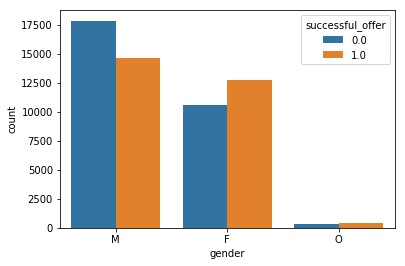

In [62]:
# plot the number of successful and unsuccesful offers based on gender
sns.countplot(x="gender", hue="successful_offer", data=master)

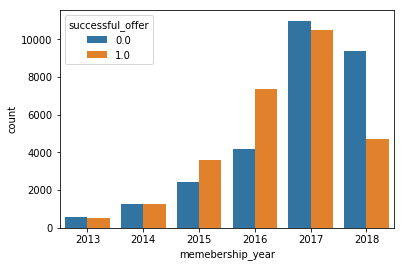

In [63]:
# plot the number of successful and unsuccesful offers based on memebership_year
sns.countplot(x="memebership_year", hue="successful_offer", data=master)

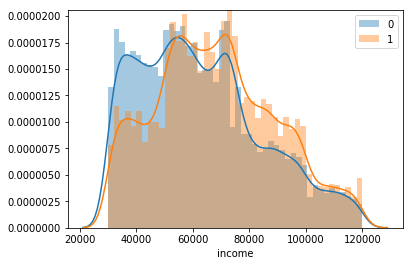

In [64]:
# plot the distribution plot of successful and unsuccesful offers based on income
sns.distplot(master[master['successful_offer']== 0]['income'],label='0')
sns.distplot(master[master['successful_offer']== 1]['income'],label='1')

plt.legend()
plt.show()

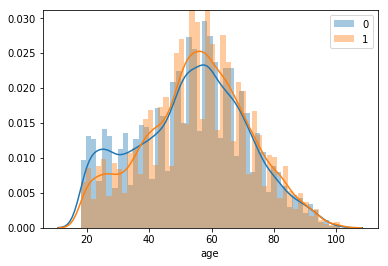

In [65]:
# plot the distribution plot of successful and unsuccesful offers based on age
sns.distplot(master[master['successful_offer']== 0]['age'],label='0')
sns.distplot(master[master['successful_offer']== 1]['age'],label='1')

plt.legend()
plt.show()

**Findings:** <br> 
1- The master dataset has 56759 entries of unique person_id and offer_id combinations.<br> 
2- There are 28820 rows of unsuccessful offer and 27939 rows of successful offers. Luckily, this create a balanced dataset.<br> 
3- The most successful offer is offer 8 where the least successful offer is offer 5.<br>
4- The offer type doesn't seem to play a huge rule in offer success.<br>
5- Females tend to have more successful offers than men.<br>
6- Customers who became members at the year 2018 have the least successful offer rate.<br>
7- The higher the income, the higher the success offer rate.<br>
8- Age doesn't seem to play a huge rule in offer success.<br>

# Predictive Modeling

## Prepare the master df for modeling

In [66]:
# use one hot encoding on the offer_type and gender columns
master = pd.concat([master, pd.get_dummies(master[['offer_type', 'gender']])], axis=1)

# drop the gender and offer_type and became_memeber_on columns
master.drop(['offer_type', 'gender', 'became_member_on'], axis=1, inplace=True)
master.head()

,offer_id,amount,reward_x,difficulty,duration,reward_y,email_channel,mobile_channel,web_channel,social_channel,...,income,successful_offer,num_success,memebership_year,offer_type_bogo,offer_type_discount,offer_type_informational,gender_F,gender_M,gender_O
0,10,69.20,2.0,10,7,2,1,1,1,0,...,72000.0,0.0,3.0,2017,0,1,0,0,1,0
1,3,0.00,0.0,0,4,0,1,1,1,0,...,72000.0,0.0,3.0,2017,0,0,1,0,1,0
2,7,27.67,2.0,10,10,2,1,1,1,1,...,72000.0,1.0,3.0,2017,0,1,0,0,1,0
3,8,22.16,0.0,0,3,0,1,1,0,1,...,72000.0,1.0,3.0,2017,0,0,1,0,1,0
4,9,8.57,5.0,5,5,5,1,1,1,1,...,72000.0,1.0,3.0,2017,1,0,0,0,1,0


In [105]:
# split the dataset into dependent and independent features
y = master['successful_offer']
X = master.drop(['successful_offer'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

## Develop ML Models

In [110]:
# Define the models to be used 
models = [
    ('Logistic Regression', LogisticRegression()), 
    ('Random Forest', RandomForestClassifier()),
    ('KNN', KNeighborsClassifier()),
    ('DT', DecisionTreeClassifier())
    ]

results = []
target_names = ['unsuccessful', 'successful']
for name, model in models:
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print('{} Test Accuracy: {}'.format(name, accuracy_score(y_test,y_pred)))

Logistic Regression Test Accuracy: 0.8973455485083393
Random Forest Test Accuracy: 0.9265327695560254
KNN Test Accuracy: 0.8981677237491191
DT Test Accuracy: 0.9084449142588678


**Findings:** <br> 
Random Forest classifier has outperformed the other three classifiers with an accuracy of 93%.
For future work, I aim to use grid search algorithm to improve the accuracy further by finding the best set of hyperparameters.

## GridSearch

In [93]:
# Create a pipeline for each model
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('LR', LogisticRegression(random_state=42))])
pipe_rf = Pipeline([('scl', StandardScaler()),
                    ('RF',RandomForestClassifier(random_state=42))])
pipe_knn = Pipeline([('scl', StandardScaler()),
                    ('KNN', KNeighborsClassifier())])
pipe_dt = Pipeline([('scl', StandardScaler()),
                    ('DT',DecisionTreeClassifier(random_state=42))])

In [94]:
# define the set of hyperparameters
param_range = [1, 2, 3, 4, 5, 6]
param_range_fl = [1.0, 0.5, 0.1]
n_estimators = [50,100,150]
learning_rates = [.1,.2,.3]
lr_param_grid = [{'LR__penalty': ['l1', 'l2'],
                   'LR__C': param_range_fl,
                   'LR__solver': ['liblinear']}]
rf_param_grid = [{'RF__min_samples_leaf': param_range,
                   'RF__max_depth': param_range,
                   'RF__min_samples_split': param_range[1:]}]
knn_param_grid = [{'KNN__n_neighbors': param_range,
                   'KNN__weights': ['uniform', 'distance'],
                   'KNN__metric': ['euclidean', 'manhattan']}]
dt_param_grid = [{'DT__criterion': ['gini', 'entropy'],
                   'DT__min_samples_leaf': param_range,
                   'DT__max_depth': param_range,
                   'DT__min_samples_split': param_range[1:]}]

In [98]:
# create the grid search models
lr_grid_search = GridSearchCV(estimator=pipe_lr,
        param_grid=lr_param_grid,
        scoring='accuracy')
rf_grid_search = GridSearchCV(estimator=pipe_rf,
        param_grid=rf_param_grid,
        scoring='accuracy')
knn_grid_search = GridSearchCV(estimator=pipe_knn,
        param_grid=knn_param_grid,
        scoring='accuracy')
dt_grid_search = GridSearchCV(estimator=pipe_dt,
        param_grid=dt_param_grid,
        scoring='accuracy')

In [99]:
# fit the models
grids = [lr_grid_search, rf_grid_search, knn_grid_search, dt_grid_search]
for pipe in grids:
    pipe.fit(X_train,y_train)

In [109]:
# print the results
grid_dict = {0: 'Logistic Regression', 1: 'Random Forest', 
             2: 'K-Nearest Neighbors', 3: 'Decision Trees'}

for i, model in enumerate(grids):
    y_pred = model.predict(X_test)
    print('{} Test Accuracy: {}'.format(grid_dict[i], accuracy_score(y_test,y_pred)))
    print('{} Best Params: {}'.format(grid_dict[i], model.best_params_))

Logistic Regression Test Accuracy: 0.8969931876908621
Logistic Regression Best Params: {'LR__C': 0.5, 'LR__penalty': 'l1', 'LR__solver': 'liblinear'}
Random Forest Test Accuracy: 0.9193093727977449
Random Forest Best Params: {'RF__max_depth': 6, 'RF__min_samples_leaf': 3, 'RF__min_samples_split': 2}
K-Nearest Neighbors Test Accuracy: 0.9729856706600892
K-Nearest Neighbors Best Params: {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 6, 'KNN__weights': 'distance'}
Decision Trees Test Accuracy: 0.9341085271317829
Decision Trees Best Params: {'DT__criterion': 'gini', 'DT__max_depth': 6, 'DT__min_samples_leaf': 1, 'DT__min_samples_split': 2}
